## Transformación de Dominio

Para esta práctica se trabaja con los datos del dataset DOTA (A Large-Scale Benchmark and Challenges for Object Detection in Aerial Images).

Enlace: https://captain-whu.github.io/DOTA/dataset.html

Se propone el siguiente algoritmo para convertir el conjunto de datos de entrada en otro más adecuado para ser tratado por una red neuronal convolucional como la vista en el primer cuaderno.

1. Cargar imágenes

2. Cargar bounding boxes

3. Extraer base $B$ de cada bounding box $\mathcal{B}$

4. Obtener la matriz $P$ que cambia de una base cualquiera $B$ a la base canónica $B'$

5. Transformar la bounding box $\mathcal{B}$ por la matriz de cambio de base $P$.

6. Tomar únicamente las celdas de la imagen delimitadas por la bounding box. Una vez en la base canónica, basta con tomar los puntos de corte en los ejes $x$ e $y$, evitando así computar el resto de la imagen.

7. Añadir el relleno que sea necesario para completar la matriz de diseño $X_{m \times n}$

8. Exportar la imagen transformada, dando lugar al dataset que posteriormente podrá ser digerido por una red neuronal convolucional

In [2]:
# Importar librerías y módulos
import numpy as np
import PIL as pil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import distance
from math import *
from recordclass import recordclass
import os
import copy
import time
%config Completer.use_jedi = False  # Simplemente acelera el autocompletado

In [3]:
# Definición de estructuras de datos
Img = recordclass('Img', ['id', 'mat', 'path'])
BBox = recordclass('BBox', ['id', 'v', 'lbl'])

## Exploración inicial

Aquí simplemente se exploran los datos. Estos consisten en una colección de imágenes tal que para cada imagen hay un conjunto de bounding boxes asociadas que aislan regiones de interés. Estas regiones de interés están etiquetadas indicando el tipo de objeto que en ellas se encuentra (ground truth).

Labels de prueba:
       0     1     2     3     4     5     6     7                   8  9
0   606   531   802   362   891   470   698   641   soccer-ball-field  0
1   533   554   793   319   934   475   668   699  ground-track-field  0
2  1145   202  1176   202  1176   234  1145   234          roundabout  0
3   798   658   900   569   966   638   861   730   soccer-ball-field  0
4   557   747   764   713   783   842   580   877   soccer-ball-field  0
5   841   257   864   257   864   282   841   282          roundabout  0
6   394  1005   454  1005   454  1066   394  1066          roundabout  0


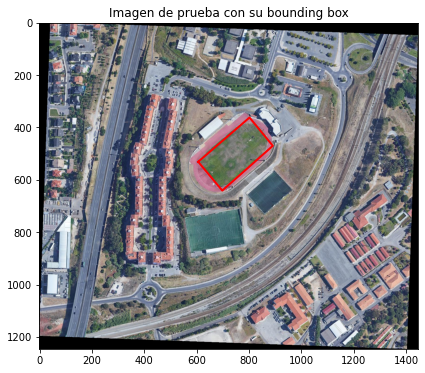

In [4]:
# Cargar caso de prueba
test_img = np.array(pil.Image.open('/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/P0164.png'))
test_lbl = pd.read_csv(
    '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/label/P0164.txt',
    delimiter=' ',
    skiprows=2,
    header=None
)
print('Labels de prueba:\n', test_lbl)
bbox = np.array(test_lbl.iloc[0, 0:8])
plt.figure(figsize=(11,6))
plt.title('Imagen de prueba con su bounding box')
plt.imshow(test_img)
plt.plot(np.concatenate([bbox[0::2], [bbox[0]]]), np.concatenate([bbox[1::2], [bbox[1]]]), color='red', lw=2)
plt.show()

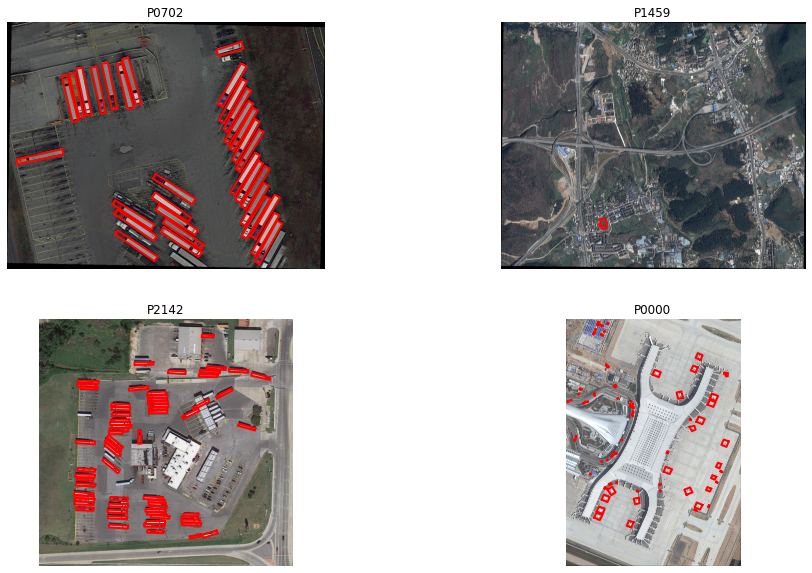

In [5]:
# Iterador funcional sobre archivos de imagen en un directorio
def list_images(dirpath, read=False):
    for entry in os.listdir(dirpath):
        img_id = entry.split('.')[0]
        img_path = dirpath + os.sep + entry
        img_mat = None
        if read:
            img_mat = np.array(pil.Image.open(img_path))
        yield Img(img_id, img_mat, img_path)
    

# Funcion para obtener la bounding box asociada a una imagen
def read_bboxes(I, dirpath):
    fpath = dirpath + os.sep + I.id + '.txt'
    data = pd.read_csv(fpath, delimiter=' ', skiprows=2, header=None)
    vertices = data.iloc[:, 0:8].to_numpy()
    labels = data.iloc[:, 8]
    bboxes = []
    for i in range(vertices.shape[0]):
        bboxes.append(BBox(I.id+str(i), vertices[i, :], labels[i]))
    return bboxes
    
# Prueba
count = 0
plt.figure(figsize=(16, 10))
for I in list_images('/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/', read=True):
    count += 1
    ax = plt.subplot(2, 2, count)
    plt.imshow(I.mat)
    for BB in read_bboxes(I, '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/label/'):
        plt.plot(
            np.concatenate([BB.v[0::2], [BB.v[0]]]),
            np.concatenate([BB.v[1::2], [BB.v[1]]]),
            color='red',
            lw=2
        )
    plt.title(I.id)
    plt.axis('off')
    if count == 4 : break
plt.show()

## Extraer la base de una bounding box

Sea $O = (O_x, O_y)$ el vértice origen de la bounding box, $P = (P_x, P_y)$ el vértice adyacente a $O$ en el eje $x$ de su sistema de referencia local y $Q = (Q_x, Q_y)$ el vértice adyacente a $O$ en el eje $y$ de su sistema de referencia local. Puede extraerse su base normalizada tal que:

$
B = 
\left[\begin{array}{ll}
{\frac{P_x-O_x}{||P-O||}} & {\frac{Q_x-O_x}{||Q-O||}} \\
{\frac{P_y-O_y}{||P-O||}} & {\frac{Q_y-O_y}{||Q-O||}}
\end{array}\right]
$

### PROBLEMA

Lo que en el dataset se llaman bounding boxes, en realidad no lo son. Una bounding box en 2D es estrictamente un rectángulo, lo que quiere decir que se compone de un conjunto de dos lados paralelos ortogonal respecto de otro conjunto de dos lados paralelos. 

Las bounding boxes que se dan están definidas sobre una matriz, que es una discretización a índices enteros del espacio. En este caso, numéricamente no se va a cumplir que el producto escalar estándar de los vectores directores de los lados que debieran ser ortogonales sea 0.

Para futuros procesamientos es deseable que la base obtenida sea ortogonal, ya que el algoritmo se basa en razonar en la base canónica, donde recortar la imagen de interés se reduce a un problema trivial.

Afortunadamente, aplicar el método de Gram-Schmidt para ortogonalizar una base en $\mathbb{R^2}$ es bastante sencillo. Sean $b_1$ y $b_2$ los vectores de la base no ortogonal, puede obtenerse una base ortogonal a partir de esta aplicando las siguientes ecuaciones:

$
\left\{\begin{array}{l}
b'_1 = b_1\\
b'_2 = b_2 - \frac{\left\langle b_2, b'_1 \right\rangle}{\left\langle b'_1 b'_1 \right\rangle} b'_1
\end{array}\right.
$

Comprobación de ortogonalidad basada en producto escalar:  -2.7755575615628914e-17


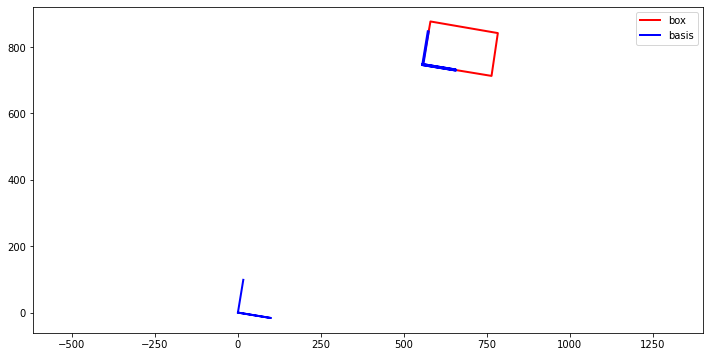

In [6]:
# Función para extraer la base de una bounding box dada
def basis_from_bbox(BB):
    O = np.array([BB.v[0], BB.v[1]])
    P = np.array([BB.v[2], BB.v[3]])
    Q = np.array([BB.v[6], BB.v[7]])
    P_O = P-O
    Q_O = Q-O
    dotQP = np.dot(Q_O, P_O)
    if abs(dotQP) > 0.00000001:  # Aplicar Gram-schmidt cuando sea necesario
        Q_O = Q_O - dotQP / np.dot(P_O, P_O) * P_O
    OPnorm = np.linalg.norm(P_O)
    OQnorm = np.linalg.norm(Q_O)
    return np.array([P_O/OPnorm, Q_O/OQnorm]).transpose()

# Prueba
test_image = Img(
    'P0164',
    np.array(pil.Image.open('/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/P0164.png')),
    '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/P0164.png'
)
test_box = read_bboxes(test_image, '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/label/')[4]
test_basis = basis_from_bbox(test_box)
print('Comprobación de ortogonalidad basada en producto escalar: ', np.dot(test_basis[:,0], test_basis[:,1]))

# Graficar
bsf = 100  # Basis scale factor
plt.figure(figsize=(12,6))
plt.plot(
    np.concatenate([test_box.v[0::2], [test_box.v[0]]]),
    np.concatenate([test_box.v[1::2], [test_box.v[1]]]),
    color='red',
    lw=2,
    label='box'
)
plt.plot(
    [0, bsf*test_basis[0,0], 0, bsf*test_basis[0,1]],
    [0, bsf*test_basis[1,0], 0, bsf*test_basis[1,1]],
    color='blue',
    lw=2,
    label='basis'
)
plt.plot(
    [test_box.v[0], test_box.v[0]+bsf*test_basis[0,0], test_box.v[0], test_box.v[0]+bsf*test_basis[0,1]],
    [test_box.v[1], test_box.v[1]+bsf*test_basis[1,0], test_box.v[1], test_box.v[1]+bsf*test_basis[1,1]],
    color='blue',
    lw=3,
)
plt.axis('equal')
plt.legend(loc='best')
plt.show()

## Aplicar cambio de base
Sean $B$ y $B'$ dos bases en $\mathbb{R}^2$ expresadas como matrices tales que sus vectores columnas son los vectores que forman las respectivas bases. Se entiende por matriz $P$ de cambio de base aquella que expresa los coeficientes de una base en función de la otra.

Considerando por conveniencia los vectores columna $\vec{b}_1 = (b_{11}, b_{21})$, $\vec{b}_2 = (b_{12}, b_{22})$, $\vec{b}_1' = (b'_{11}, b'_{21})$ y $\vec{b}_2' = (b'_{12}, b'_{22})$ y denotando las matrices tal que:

$
P = \left[\begin{array}{ll}
p_{11} & p_{12} \\
p_{21} & p_{22}
\end{array}\right],
B = \left[\begin{array}{ll}
b_{11} & b_{12} \\
b_{21} & b_{22}
\end{array}\right],
B' = \left[\begin{array}{ll}
b'_{11} & b'_{12} \\
b'_{21} & b'_{22}
\end{array}\right]
$

Se sabe que la base $B'$ puede expresarse como $B' = B P$. Por tanto, puede determinarse $P$ multiplicando ambos lados por la izquierda por $(B)^{-1}$, tal que $P = (B)^{-1} B'$.

Finalmente, cualquier punto $Q=(x, y)$ en la base $B$ puede cambiarse a la base $B'$ multiplicándolo por la matriz de cambio de base tal que $Q' = PQ$

**NOTA** *En este caso el cambio de base da lugar a cálculos sencillos. Para problemas más complicados es mejor idea utilizar `np.linalg.solve` que se encarga de resolver el sistema condicionándolo adecuadamente para minimizar el impacto de posibles pérdidas de precisión decimal.*

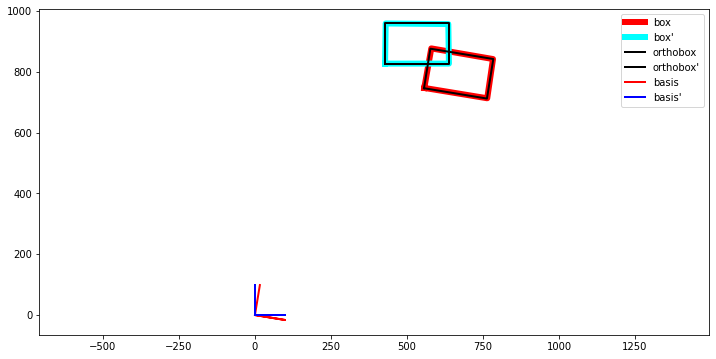

In [6]:
# Determinar la matriz de cambio de base de B1 a B2
def change_of_basis_matrix(B1, B2):
    return np.matmul(np.linalg.inv(B1), B2)
    
# Cambiar la base de una bounding box
def change_bbox_basis(P, BB):
    BB2 = copy.deepcopy(BB)
    for i in range(0, 8, 2):
        BB2.v[i:i+2] = np.matmul(P, BB2.v[i:i+2])                            
    return BB2

# Función que ortogonaliza una axis aligned bounding box para que sea realmente un rectángulo
def axis_aligned_orthogonalize(BB):
    X = BB.v[0::2]
    Y = BB.v[1::2]
    xmin = np.min(X)
    xmax = np.max(X)
    ymin = np.min(Y)
    ymax = np.max(Y)
    BB.v = np.array([xmin, ymin, xmin, ymax, xmax, ymax, xmax, ymin])

# Prueba
P = change_of_basis_matrix(test_basis, np.eye(2))
P_ = np.linalg.inv(P)
test_basis2 = np.concatenate([
    np.matmul(P, test_basis[:,0]),
    np.matmul(P, test_basis[:,1])
]).reshape(2, 2)
test_box2 = change_bbox_basis(P, test_box)
test_obox2 = copy.deepcopy(test_box2)
axis_aligned_orthogonalize(test_obox2)
test_obox = change_bbox_basis(P_, test_obox2)

# Graficar
plt.figure(figsize=(12,6))
plt.plot(
    np.concatenate([test_box.v[0::2], [test_box.v[0]]]),
    np.concatenate([test_box.v[1::2], [test_box.v[1]]]),
    color='red',
    lw=6,
    label='box'
)
plt.plot(
    np.concatenate([test_box2.v[0::2], [test_box2.v[0]]]),
    np.concatenate([test_box2.v[1::2], [test_box2.v[1]]]),
    color='cyan',
    lw=6,
    label='box\''
)
plt.plot(
    np.concatenate([test_obox.v[0::2], [test_obox.v[0]]]),
    np.concatenate([test_obox.v[1::2], [test_obox.v[1]]]),
    color='black',
    lw=2,
    label='orthobox'
)
plt.plot(
    np.concatenate([test_obox2.v[0::2], [test_obox2.v[0]]]),
    np.concatenate([test_obox2.v[1::2], [test_obox2.v[1]]]),
    color='black',
    lw=2,
    label='orthobox\''
)
plt.plot(
    [0, bsf*test_basis[0,0], 0, bsf*test_basis[0,1]],
    [0, bsf*test_basis[1,0], 0, bsf*test_basis[1,1]],
    color='red',
    lw=2,
    label='basis'
)
plt.plot(
    [0, bsf*test_basis2[0,0], 0, bsf*test_basis2[0,1]],
    [0, bsf*test_basis2[1,0], 0, bsf*test_basis2[1,1]],
    color='blue',
    lw=2,
    label='basis\''
)
plt.axis('equal')
plt.legend(loc='best')
plt.show()

## Procesar la imagen

Se cambia la bounding box a la base canónica. A continuación, se extraen las coordenadas de las celdas de la matriz contenidas en la bounding box. Luego, se llevan de vuelta a la base original. Para realizar este paso, basta con multiplicar por $P^{-1}$ para regresar a la base de partida. Por último, se añade el relleno que sea necesario y así se obtiene la matriz de diseño $m \times n$ lista para ser tratada por una red neuronal convolucional en trabajos posteriores.

Recortar la imagen en la base canónica resulta muy sencillo, porque basta con tomar todos los puntos $(x,y)$ que satisfagan $x \in [x_0, x_1] \land y \in [y_0, y_1]$. Donde $[x_0, x_1]$ es el intervalo entre el mínimo y el máximo valor de la coordenada $x$ para la bounding box y $[y_0, y_1]$ es análogo pero para la coordenada $y$.

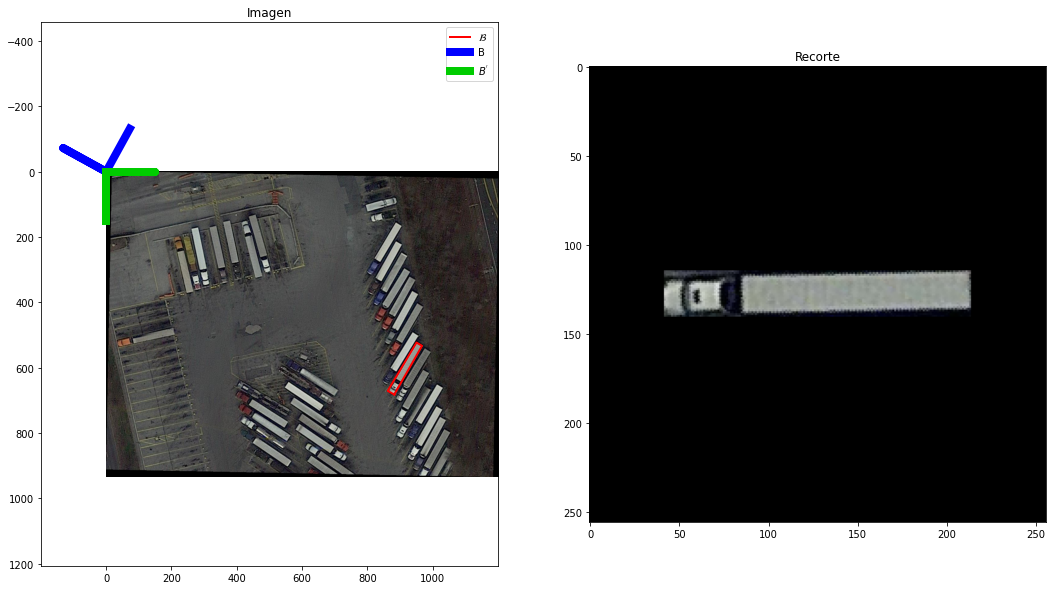

In [7]:
# Función que recorta la imagen en función de la bounding box y el tamaño de salida deseado
def image_processing(I, BB, P, P_, dim):
    # Escalar la bounding box
    BB_ = change_bbox_basis(P, BB)
    axis_aligned_orthogonalize(BB_)
    x0, x1 = BB_.v[0], BB_.v[6]
    y0, y1 = BB_.v[1], BB_.v[3]

    # Extraer índices
    xset = np.arange(floor(x0), ceil(x1))
    yset = np.arange(floor(y0), ceil(y1))
    cartesian_indices = [[xidx, yidx] for xidx in xset for yidx in yset]  # Producto cartesiano
    
    # Traducir índices a la base original
    transformed_indices = [np.matmul(P_, cartesian_indices[i]) for i in range(len(cartesian_indices))]
    transformed_indices = np.array(transformed_indices).astype(int)
    
    # Computar la imagen transformada
    transformed_indices[:,0] = np.clip(transformed_indices[:,0], 0, I.mat.shape[1])
    transformed_indices[:,1] = np.clip(transformed_indices[:,1], 0, I.mat.shape[0])
    X = I.mat[[transformed_indices[:,1]], [transformed_indices[:,0]]] \
        .reshape([xset.shape[0], yset.shape[0], 3])
    
    # Añadir relleno (padding) donde sea necesario
    Z = np.zeros([dim[0], dim[1], 3]).astype(int)
    offset = np.divide(dim, 2).astype(int) - np.divide(X.shape[:2], 2).astype(int)
    Z[offset[0]+0:offset[0]+X.shape[0], offset[1]+0:offset[1]+X.shape[1]] = X
    
    # Devolver resultado
    return Z
    
    
    
# Prueba
test_I = Img(
    'P0702',
    np.array(pil.Image.open('/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/P0702.png')),
    '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/P0702.png'
)
test_BB = read_bboxes(test_I, '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/label/')[5]
test_B = basis_from_bbox(test_BB)
test_P = change_of_basis_matrix(test_B, np.eye(2))
test_P_ = np.linalg.inv(test_P)
X = image_processing(test_I, test_BB, test_P, test_P_, [256, 256])

# Graficar
plt.figure(figsize=(18, 10))

# Graficar la imagen original y las bases
ax = plt.subplot(1, 2, 1)
plt.title('Imagen')
ax.imshow(test_I.mat)
ax.plot(
    np.concatenate([test_BB.v[0::2], [test_BB.v[0]]]),
    np.concatenate([test_BB.v[1::2], [test_BB.v[1]]]),
    color='red',
    lw=2,
    label='$\mathcal{B}$',
)
bsf = 150  # Basis scale factor
ax.plot(
    [0, bsf*test_B[0,0], 0, bsf*test_B[0,1]],
    [0, bsf*test_B[1,0], 0, bsf*test_B[1,1]],
    color='blue',
    lw=8,
    label='B'
)
ax.plot(
    bsf*np.array([0, 1, 0, 0]),
    bsf*np.array([0, 0, 0, 1]),
    color='#00CC00',
    lw=8,
    label='$B^{\'}$'
)
plt.legend(loc='best')
plt.axis('equal')


# Graficar la imagen recortada
ax = plt.subplot(1, 2, 2)
plt.title('Recorte')
ax.imshow(X)

# Mostrar lo graficado
plt.show()

## Control de ejecución y exportar

Por último, se definen algunas funciones para contorlar el flujo de ejecución y exportar los datos transformados.

In [8]:
# Función para traducir una etiqueta textual a su número entero correspondiente
def label_to_int(lbl):
    if lbl == 'plane' : return 0
    if lbl == 'ship' : return 1
    if lbl == 'storage-tank' : return 2
    if lbl == 'baseball-diamond' : return 3
    if lbl == 'tennis-court' : return 4
    if lbl == 'basketball-court' : return 5
    if lbl == 'ground-track-field' : return 6
    if lbl == 'harbor' : return 7
    if lbl == 'bridge' : return 8
    if lbl == 'large-vehicle' : return 9
    if lbl == 'small-vehicle' : return 10
    if lbl == 'helicopter' : return 11
    if lbl == 'roundabout' : return 12
    if lbl == 'soccer-ball-field' : return 13
    if lbl == 'swimming-pool' : return 14
    raise Exception('Unexpected label exception')

# Función para comprobar si hay suficientes casos de una categoría determinada
def is_label_necessary(H, lbl, max_cases=[8 for i in range(15)]):
    lbl_id = label_to_int(lbl)
    return H[lbl_id] < max_cases[lbl_id]

# Función para comprobar si ya se han obtenido todos los casos deseados para cada clase
def requirements_fulfilled(H, max_cases=[8 for i in range(15)]):
    for i, h in enumerate(H):
        if h < max_cases[i]:
            return False
    return True

# Función para exportar la imagen con su ground truth y actualizar el histórico
def export_new_image(X, img_count, BB, output_path, gt_file, H):
    # Exportar imagen
    img = pil.Image.fromarray(np.uint8(X))
    img_path = output_path + os.sep + 'IMG_' + str(img_count) + ".png"
    img.save(img_path)
    
    # Exportar ground truth
    gt_file.write(BB.lbl + ',"' + img_path + '"\n')
    
    # Actualizar contador
    lbl_id = label_to_int(BB.lbl)
    H[lbl_id] += 1

## Ejecución principal

Ahora que todas las funciones necesarias están codificadas, se puede articular un sencillo algoritmo que transforme los datos originales en otro conjunto de datos listo para ser tratado por una red neuronal convolucional. En el siguiente cuaderno se verá como entrenar y aplicar dicha red al nuevo conjunto de datos.

In [10]:
# ---  El inicio de los tiempos  --- #
# ---------------------------------- #
start = time.perf_counter()


# ---  Argumentos de entrada  --- #
# ------------------------------- #
# Código de ejecución principal : COMIENZO
images_dir = '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/image/'  # Directorio donde estan las imagenes
labels_dir = '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/label/'  # Directorio donde esta el ground truth
output_path = '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/cnn_data/'  # Directorio de salida
gt_path = '/smalldata/phd/AerialImagesCNN/datasets/dota1_0/cnn_data/gt.csv'  # Donde exportar ground truth
B_ = np.eye(2)  # Base canónica, B'
m = 333  # Número de filas que debe tener cada imagen transformada
n = 333  # Número de columnas que debe tener cada imagen transformada
dim = [m, n]  # Vector de dimensiones de la matriz de salida
num_labels = 15  # Cuantas categorías de clasificación diferentes existen
H = [0 for i in range(num_labels)]  # Histórico de ocurrencias para cada categoría
fin = False  # Indicador de fin
img_count = 0  # Contador para saber cuantas imágenes han sido exportadas
# Cuantos casos se desean de cada cateogría
max_cases = [
    4096,     # Aviones
    4096,     # Barcos
    4096,     # Depósitos de almacenamiento
     198,     # Campo de baseball
    2358,     # Pista de tenis
     487,     # Pista de baloncesto
     137,     # Pista de tierra
    4096,     # Puerto
     206,     # Puente
    4096,     # Vehículo grande
    4096,     # Vehículo pequeño
     628,     # Helicóptero
     208,     # Rotonda
     164,     # Campo de futbol
    1727      # Piscina
]

# ---  Lógica del algoritmo  --- #
# ------------------------------ #
# Explorando un espacio de datos con una asociación 1..n
# Donde 1 imagen está asociada a n etiquetados basados en bounding box
# Donde n etiquetados en bounding boxes están asociados a 1 única imagen que los identifica unívocamente
# En un esquema de clave (Key) valor (Value) <K, V> -> Map(K) = (BB1, ..., BBn)
# Esto permite organizar eficientemente los datos, como una primera aproximación genérica y sencilla
gt_file = open(gt_path, 'w')  # Abrir archivo donde escribir el CSV del ground truth (label, imagen)
for I in list_images(images_dir, read=False):  # Por cada imagen
    try:  # Activar control de excepciones para la lectura de bounding boxes
        for BB in read_bboxes(I, labels_dir):  # Por cada bounding box asociada a la imagen
            if not is_label_necessary(H, BB.lbl, max_cases):  # Si ya hay suficientes casos de este tipo
                continue  # Ir a la siguiente iteración
            I.mat = np.array(pil.Image.open(I.path))  # Cargar la imagen, pues es necesario procesarla
            B = basis_from_bbox(BB)  # Obtener base asociada a la bounding box
            P = change_of_basis_matrix(B, B_)  # Aplicar cambio de base
            P_ = np.linalg.inv(P)  # Obtener la inversa del cambio de base
            try:  # Activar control de excepciones para el procesamiento de imagen
                X = image_processing(I, BB, P, P_, dim)  # Procesar imagen para adecuarla a la CNN
            except Exception as ex:  # Capturar excepciones (generalmente causadas por tamaño excesivo)
                continue  # Siguiente iteracion
            export_new_image(X, img_count, BB, output_path, gt_file, H)  # Exportar la imagen procesada 
            img_count += 1  # Incrementar contador de imágenes exportadas
            print(f'\rCasos procesados: {H} ', end='')  # Mostar progreso
            if requirements_fulfilled(H, max_cases):  # Si se ha cumplido el objetivo
                fin = True  # Indicar que se ha finalizado
                break  # Evitar iteraciones ociosas del bucle interior
        if fin:  # Comprobar si se ha finalizado
            break  # Evitar iteraciones ociosas del bucle exterior cuando se haya finalizado
    except Exception as ex:  # Capturar excepciones (a veces no hay bounding box legible)
        continue  # Siguiente iteración
print('\n', end='')  # Añadir un salto de línea
gt_file.close()  # Cerrar archivo CSV de ground truth ahora que se ha terminado de escribir
# Código de ejecución principal : FINAL


# ---  El fin de los tiempos  --- #
# ------------------------------- #
end = time.perf_counter()
print(f'Programa principal ejecutado en {end-start} segundos')

Casos procesados: [4096, 4096, 4096, 198, 2358, 487, 137, 4096, 206, 4096, 4096, 628, 208, 164, 1727] 
Programa principal ejecutado en 10611.513846158981 segundos
